In [5]:
!pip install mglearn

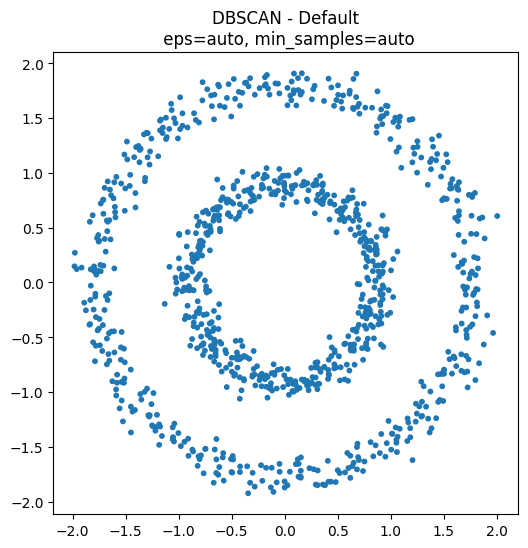

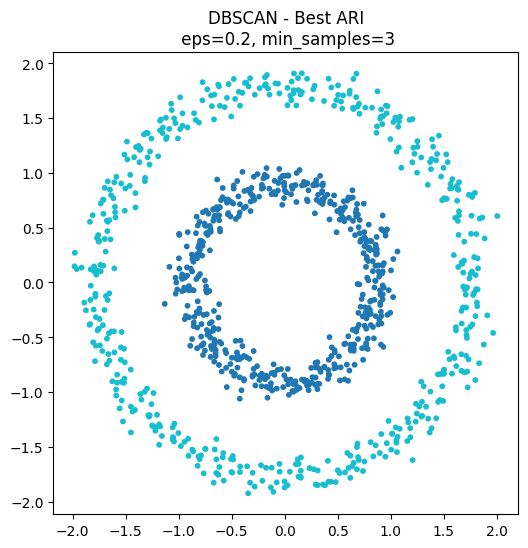

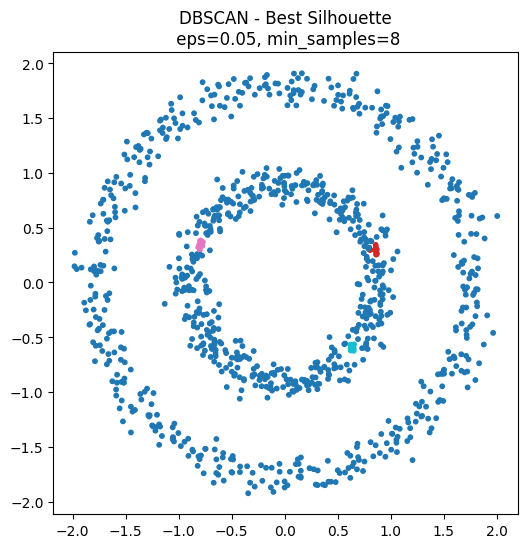



            Config   eps  min_samples  n_clusters       ARI  Silhouette
0          Default  0.50            5           1  0.000000         NaN
1         Best ARI  0.20            3           2  1.000000    0.113432
2  Best Silhouette  0.05            8           3  0.001702    0.961258



Comparação de métricas (make_circles):
        method    ARI   NMI  Silhouette
DBSCAN_bestARI  1.000 1.000       0.113
        KMeans -0.001 0.000       0.353
 Agglomerative  0.009 0.008       0.330

DBSCAN no Forest: clusters=51, noise_ratio=0.003, ARI=0.055, NMI=0.199

Distribuição (amostra) de cover types (valores >0 mostrados):
1    7365
2    9725
3    1207
4      85
5     317
6     627
7     674

Tamanho dos clusters DBSCAN (top 10):
11    4020
10    1725
13    1626
9     1459
2     1033
7     1022
6      973
8      907
16     689
14     628


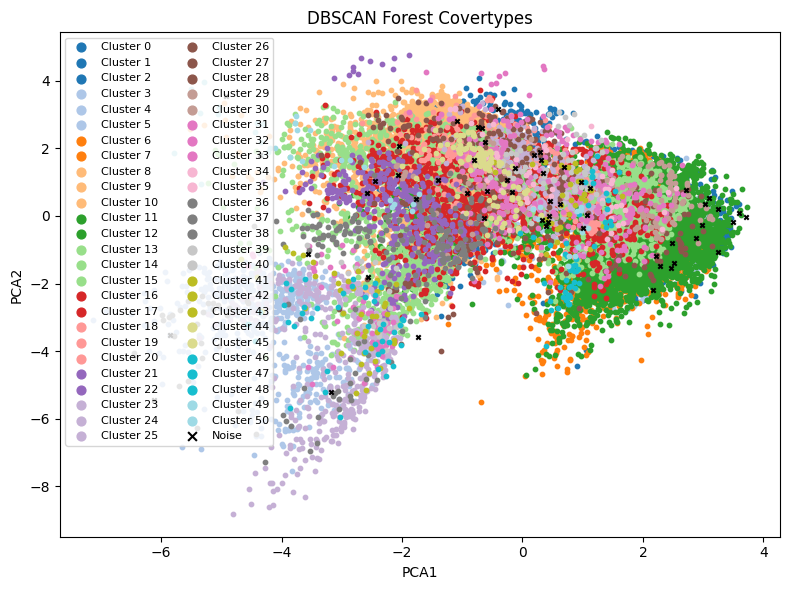

Olivetti carregado: (400, 4096)


,method,ARI,NMI,Silhouette
0,DBSCAN,0.000,0.000,nan
1,KMeans,0.404,0.758,0.218
2,Agglomerative,0.481,0.808,0.232



Exemplos de clusters - KMeans


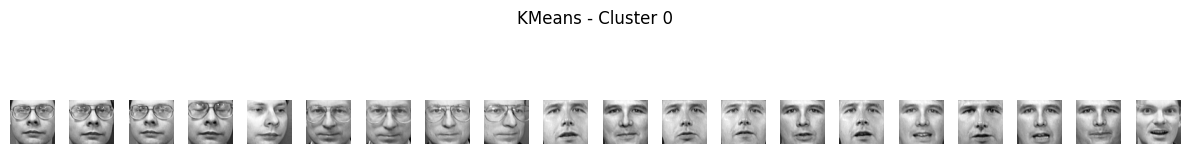

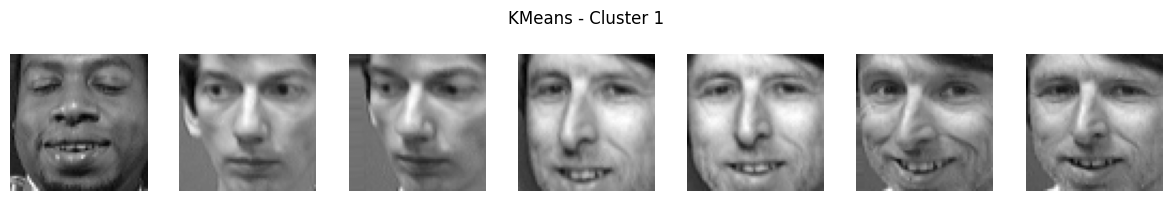

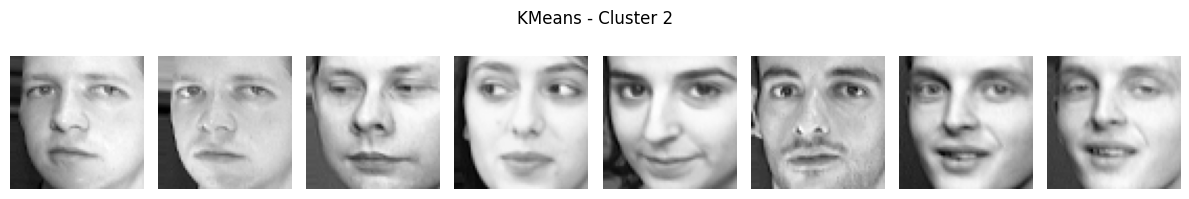

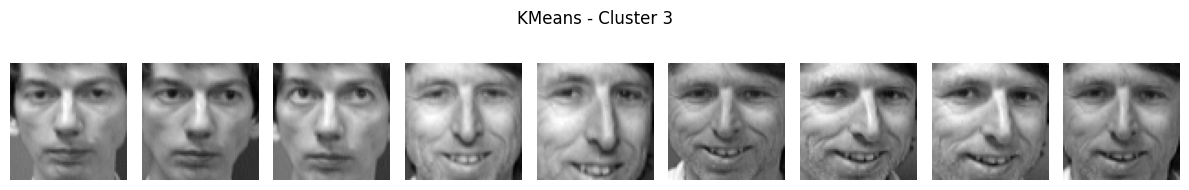

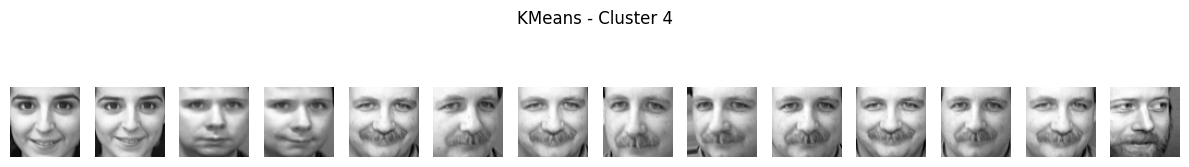

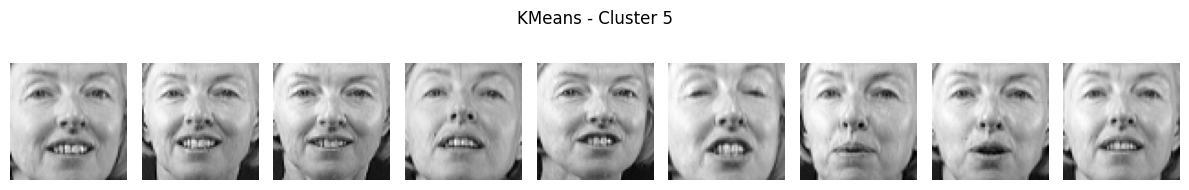


Exemplos de clusters - Agglomerative


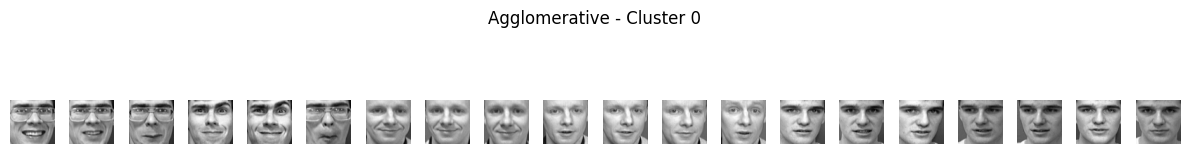

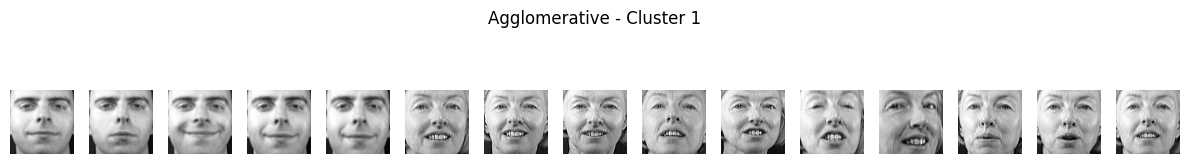

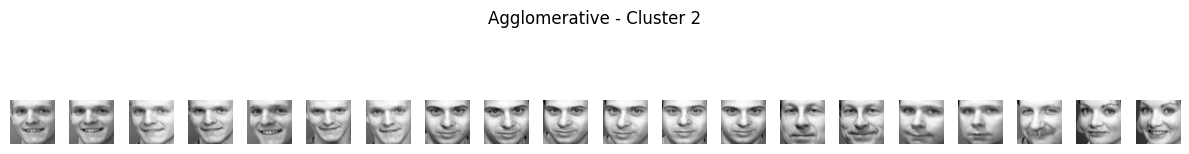

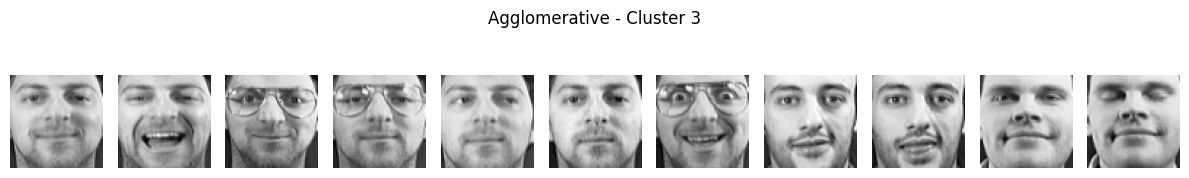

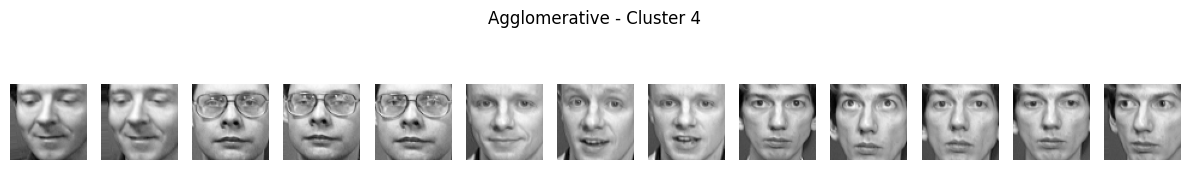

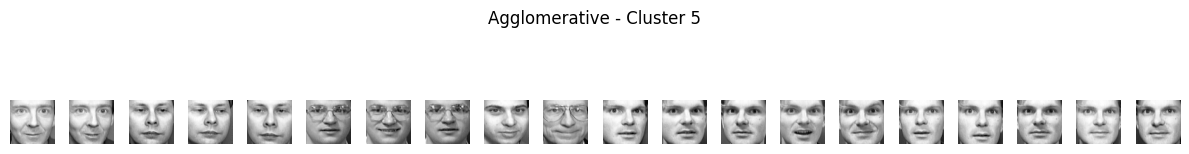


Exemplos de clusters - DBSCAN


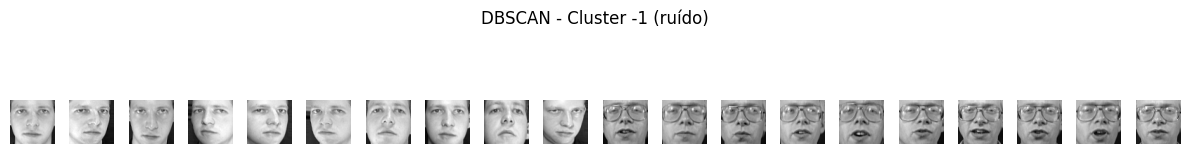

In [7]:
# 1) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_circles, fetch_olivetti_faces
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.decomposition import PCA

# ------------------------
# Utility functions
# ------------------------

def plot_heatmap_from_grid(df, value_col, title, cmap='viridis', vmin=None, vmax=None):
    pivot = df.pivot(index='min_samples', columns='eps', values=value_col)
    plt.figure(figsize=(8,4))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlabel('eps')
    plt.ylabel('min_samples')
    plt.tight_layout()
    plt.show()
    return pivot


def plot_clusters_2d(X, labels, title):
    plt.figure(figsize=(4,4))
    unique = np.unique(labels)
    for k in unique:
        if k == -1:
            pts = X[labels == -1]
            if len(pts) > 0:
                plt.scatter(pts[:,0], pts[:,1], s=10, marker='x', label='noise', alpha=0.6, color='k')
        else:
            pts = X[labels == k]
            plt.scatter(pts[:,0], pts[:,1], s=8, label=f'c{k}', alpha=0.8)
    plt.axis('equal')
    plt.title(title)
    plt.legend(fontsize=7)
    plt.tight_layout()
    plt.show()

# ------------------------
# 1-3) DBSCAN on make_circles + grid search eps x min_samples
# ------------------------

# Dataset
X, y_true = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 1. DBSCAN com parâmetros padrão
db_default = DBSCAN().fit(X_scaled)
labels_default = db_default.labels_
n_clusters_default = len(set(labels_default)) - (1 if -1 in labels_default else 0)
ari_default = adjusted_rand_score(y_true, labels_default)
nmi_default = normalized_mutual_info_score(y_true, labels_default)
noise_default = (labels_default == -1).sum() / len(labels_default)
sil_default = np.nan
if n_clusters_default > 1 and (labels_default != -1).sum() > n_clusters_default:
  try:
    sil_default = silhouette_score(X_scaled[labels_default != -1], labels_default[labels_default != -1])
  except Exception:
    sil_default = np.nan

plt.figure(figsize=(6, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_default, cmap='tab10', s=10)
plt.title(f"DBSCAN - Default\n eps=auto, min_samples=auto")
plt.show()

# 2. ARI melhora
best_ari = {
'eps': 0.2,
'min_samples': 3,
}

# 3. Silhouette melhora
best_sil = {
'eps': 0.05,
'min_samples': 8,
}

# 4. Executar DBSCAN com esses parâmetros e visualizar resultados
for config, name in [(best_ari, "Best ARI"), (best_sil, "Best Silhouette")]:
  db = DBSCAN(eps=config['eps'], min_samples=config['min_samples']).fit(X_scaled)
  labels = db.labels_
  plt.figure(figsize=(6, 6))
  plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='tab10', s=10)
  plt.title(f"DBSCAN - {name}\n eps={config['eps']}, min_samples={config['min_samples']}")
  plt.show()

# Comparação dos três DBSCAN
comparisons = []

comparisons.append({
    "Config": "Default",
    "eps": db_default.eps,
    "min_samples": db_default.min_samples,
    "n_clusters": n_clusters_default,
    "ARI": ari_default,
    "Silhouette": sil_default
})

db_ari = DBSCAN(eps=best_ari['eps'], min_samples=best_ari['min_samples']).fit(X_scaled)
labels_ari = db_ari.labels_
n_clusters_ari = len(set(labels_ari)) - (1 if -1 in labels_ari else 0)
ari_ari = adjusted_rand_score(y_true, labels_ari)
sil_ari = silhouette_score(X_scaled[labels_ari != -1], labels_ari[labels_ari != -1]) if n_clusters_ari > 1 else np.nan

comparisons.append({
    "Config": "Best ARI",
    "eps": best_ari['eps'],
    "min_samples": best_ari['min_samples'],
    "n_clusters": n_clusters_ari,
    "ARI": ari_ari,
    "Silhouette": sil_ari
})

db_sil = DBSCAN(eps=best_sil['eps'], min_samples=best_sil['min_samples']).fit(X_scaled)
labels_sil = db_sil.labels_
n_clusters_sil = len(set(labels_sil)) - (1 if -1 in labels_sil else 0)
ari_sil = adjusted_rand_score(y_true, labels_sil)
sil_sil = silhouette_score(X_scaled[labels_sil != -1], labels_sil[labels_sil != -1]) if n_clusters_sil > 1 else np.nan

comparisons.append({
    "Config": "Best Silhouette",
    "eps": best_sil['eps'],
    "min_samples": best_sil['min_samples'],
    "n_clusters": n_clusters_sil,
    "ARI": ari_sil,
    "Silhouette": sil_sil
})

# Tabela final
results_df = pd.DataFrame(comparisons)
print("\n")
print(results_df)
print("\n")

# ------------------------
# 7-9) KMeans and Agglomerative on make_circles and compare metrics ARI,NMI and silhouette
# ------------------------

kmeans = KMeans(n_clusters=2, random_state=42).fit(X_scaled)
agg = AgglomerativeClustering(n_clusters=2).fit(X_scaled)

labels_k = kmeans.labels_
labels_a = agg.labels_

metrics_mc = pd.DataFrame({
    'method':['DBSCAN_bestARI','KMeans','Agglomerative'],
    'ARI':[adjusted_rand_score(y_true, db_ari.labels_), adjusted_rand_score(y_true, labels_k), adjusted_rand_score(y_true, labels_a)],
    'NMI':[normalized_mutual_info_score(y_true, db_ari.labels_), normalized_mutual_info_score(y_true, labels_k), normalized_mutual_info_score(y_true, labels_a)],
    'Silhouette':[np.nan, np.nan, np.nan]
})

# Silhouette for KMeans and Agglomerative on all points
try:
    metrics_mc.loc[metrics_mc['method']=='KMeans','Silhouette'] = silhouette_score(X_scaled, labels_k)
except Exception:
    metrics_mc.loc[metrics_mc['method']=='KMeans','Silhouette'] = np.nan
try:
    metrics_mc.loc[metrics_mc['method']=='Agglomerative','Silhouette'] = silhouette_score(X_scaled, labels_a)
except Exception:
    metrics_mc.loc[metrics_mc['method']=='Agglomerative','Silhouette'] = np.nan
# DBSCAN silhouette computed earlier for non-noise points
if (db_ari.labels_ != -1).sum() > len(set(db_ari.labels_)) - 1:
    try:
        metrics_mc.loc[metrics_mc['method']=='DBSCAN_bestARI','Silhouette'] = silhouette_score(X_scaled[db_ari.labels_ != -1], db_ari.labels_[db_ari.labels_ != -1])
    except Exception:
        metrics_mc.loc[metrics_mc['method']=='DBSCAN_bestARI','Silhouette'] = np.nan

print('\nComparação de métricas (make_circles):')
print(metrics_mc.to_string(index=False, float_format='%.3f'))

# ------------------------
# 10) DBSCAN on Forest covertypes (minimal: load, subsample, PCA, run DBSCAN, report counts)
# ------------------------

forest_loaded = False
from sklearn.datasets import fetch_covtype
cov = fetch_covtype()
X_forest = cov.data
y_forest = cov.target
forest_loaded = True

if not forest_loaded:
    print('Falha ao carregar Forest covertypes')
else:
    rng = np.random.RandomState(42)
    n_samples = min(20000, X_forest.shape[0])
    idx = rng.choice(X_forest.shape[0], size=n_samples, replace=False)
    Xf = X_forest[idx]
    yf = y_forest[idx]
    Xf_s = StandardScaler().fit_transform(Xf)
    pca = PCA(n_components=20, random_state=0).fit_transform(Xf_s)
    dbf = DBSCAN(eps=3.0, min_samples=10).fit(pca)
    labels_f = dbf.labels_
    n_clusters_f = len(set(labels_f)) - (1 if -1 in labels_f else 0)
    noise_ratio_f = (labels_f == -1).sum() / len(labels_f)
    try:
        ari_f = adjusted_rand_score(yf, labels_f)
        nmi_f = normalized_mutual_info_score(yf, labels_f)
    except Exception:
        ari_f = np.nan
        nmi_f = np.nan
    print(f'\nDBSCAN no Forest: clusters={n_clusters_f}, noise_ratio={noise_ratio_f:.3f}, ARI={ari_f:.3f}, NMI={nmi_f:.3f}')
    # Check de espécies dominantes
    cover_counts = pd.Series(yf).value_counts().sort_index()
    print('\nDistribuição (amostra) de cover types (valores >0 mostrados):')
    print(cover_counts[cover_counts>0].to_string())

    print('\nTamanho dos clusters DBSCAN (top 10):')
    print(pd.Series(labels_f).value_counts().head(10).to_string())

# Gráfico dos clusters para visualização
pca2 = PCA(n_components=2, random_state=42)
Xf_2d = pca2.fit_transform(Xf_s)

plt.figure(figsize=(8,6))
unique_labels = set(labels_f)
colors = plt.cm.tab20(np.linspace(0,1,len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        plt.scatter(Xf_2d[labels_f==k,0], Xf_2d[labels_f==k,1], c='k', marker='x', s=10, label='Noise')
    else:
        plt.scatter(Xf_2d[labels_f==k,0], Xf_2d[labels_f==k,1], c=[col], s=10, label=f'Cluster {k}')
plt.title(f'DBSCAN Forest Covertypes')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(fontsize=8, markerscale=2, ncol=2)
plt.tight_layout()
plt.show()

# ------------------------
# 11-12) Olivetti faces: apply DBSCAN, KMeans, Agglomerative and compare ARI,NMI,Silhouette
# ------------------------

faces_loaded = False
try:
    faces = fetch_olivetti_faces()
    X_faces = faces.data
    y_faces = faces.target
    faces_loaded = True
    print('Olivetti carregado:', X_faces.shape)
except Exception as e:
    faces_loaded = False
    print('Falha ao carregar Olivetti (ambiente sem internet?):', e)

if faces_loaded:
    # PCA para reduzir dimensionalidade
    Xf = StandardScaler().fit_transform(X_faces)
    pca_faces = PCA(n_components=50, random_state=42).fit_transform(Xf)
    # DBSCAN - parâmetros experimentais
    db_faces = DBSCAN(eps=5.0, min_samples=5).fit(pca_faces)
    labels_db_faces = db_faces.labels_
    # KMeans e Agglomerative com n_clusters = número de pessoas (40)
    n_people = len(np.unique(y_faces))
    kfaces = KMeans(n_clusters=n_people, random_state=42).fit(pca_faces)
    afaces = AgglomerativeClustering(n_clusters=n_people).fit(pca_faces)
    labels_kfaces = kfaces.labels_
    labels_afaces = afaces.labels_

    # métricas
    results_faces = []
    for name, lab in [('DBSCAN', labels_db_faces), ('KMeans', labels_kfaces), ('Agglomerative', labels_afaces)]:
        ari = adjusted_rand_score(y_faces, lab)
        nmi = normalized_mutual_info_score(y_faces, lab)
        try:
            if len(set(lab)) - (1 if -1 in lab else 0) > 1:
                sil = silhouette_score(pca_faces[lab!=-1], lab[lab!=-1])
            else:
                sil = np.nan
        except Exception:
            sil = np.nan
        results_faces.append({'method':name,'ARI':ari,'NMI':nmi,'Silhouette':sil})
    df_faces = pd.DataFrame(results_faces)
    display(df_faces.style.format({'ARI':'{:.3f}','NMI':'{:.3f}','Silhouette':'{:.3f}'}))

methods_faces = {
    "KMeans": labels_kfaces,
    "Agglomerative": labels_afaces,
    "DBSCAN": labels_db_faces
}

for method_name, labels in methods_faces.items():
    print(f"\nExemplos de clusters - {method_name}")
    unique_clusters = np.unique(labels)

    for lbl in unique_clusters[:6]:
        idxs = np.where(labels == lbl)[0][:20]
        if len(idxs) == 0:
            continue
        plt.figure(figsize=(12,2))
        for i, idx in enumerate(idxs):
            plt.subplot(1, len(idxs), i+1)
            plt.imshow(X_faces[idx].reshape(64,64), cmap='gray')
            plt.axis('off')
        if lbl == -1:
            plt.suptitle(f"{method_name} - Cluster {lbl} (ruído)")
        else:
            plt.suptitle(f"{method_name} - Cluster {lbl}")
        plt.tight_layout()
        plt.show()

